In [1]:
import pickle
import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
import statsmodels.api as sm



import warnings
warnings.filterwarnings('ignore')

import wbgapi as wb

from bs4 import BeautifulSoup
import requests
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.9", "Referer": "https://www.ewg.org/tapwater/", "Connection": "keep-alive"}



In [2]:
df=pd.read_csv('world_bank.csv')

In [3]:
df.head()

,country_code,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023,YR2024,indicator_name
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fertilizer consumption (% of fertilizer produc...
1,AFE,140.033194,153.212052,158.713093,145.043828,171.539701,162.631844,230.443499,197.343427,221.710208,...,708.291645,752.710370,714.993810,831.583367,930.177029,876.412798,815.587170,NaN,NaN,Fertilizer consumption (% of fertilizer produc...
2,AFG,100.000000,100.000000,104.753566,166.820931,170.469730,190.486853,141.012701,96.488541,94.179066,...,662.618287,986.802030,847.546531,535.526728,427.561572,255.254747,248.022811,324.29028,NaN,Fertilizer consumption (% of fertilizer produc...
3,AFW,138.211678,51.640760,872.676507,730.920242,767.847847,1115.063062,4661.143295,997.361838,2304.857577,...,165.207609,212.782452,203.247372,208.216797,250.471825,227.652901,88.713296,NaN,NaN,Fertilizer consumption (% of fertilizer produc...
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fertilizer consumption (% of fertilizer produc...


df=df.melt(id_vars=['country_code','indicator_name'], value_name='value', var_name='year')

In [4]:
import pycountry

happy_df = pd.read_html('https://www.theglobaleconomy.com/rankings/happiness/')[0][['Countries', 'Happiness index, 2024']]

def to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

happy_df['iso3'] = happy_df['Countries'].apply(to_iso3)

fix = {
    'UK': 'GBR',
    'UA Emirates': 'ARE',
    'Bosnia & Herz.': 'BIH',
    'Domin. Rep.': 'DOM',
    'Russia': 'RUS',
    'Ivory Coast': 'CIV',
    'Turkey': 'TUR',
    'Burma': 'MMR',
    'Swaziland': 'SWZ'
}

happy_df['iso3'] = happy_df['Countries'].apply(
    lambda x: fix[x] if x in fix else (
        pycountry.countries.lookup(x).alpha_3 if isinstance(x, str) else None
    )
)

happy_df=happy_df[['iso3', 'Happiness index, 2024']]


In [ ]:
indicators=df['indicator_name'].unique()


happiness_index_corr_dict={}

for i, indicator in enumerate(indicators, start=1):
    filtered=df[df['indicator_name']==indicator]
    df_long=filtered.melt(id_vars=['country_code','indicator_name'], value_name='value', var_name='year')
    grouped=df_long.groupby('country_code')['value'].mean().reset_index()
    merged=grouped.merge(happy_df, left_on='country_code', right_on='iso3')

    occurance=merged.dropna(subset=['value', 'Happiness index, 2024']).shape[0]
    corr=float(merged['value'].corr(merged['Happiness index, 2024']))

    happiness_index_corr_dict[indicator]={'corr':corr, 'occurance':occurance}

    print(f'{i}/{len(indicators)}',end='\r')


df_happiness_corr = (
    pd.DataFrame.from_dict(happiness_index_corr_dict, orient='index')
      .reset_index()
      .rename(columns={'index': 'Indicator'})
      .sort_values('corr', ascending=False)
)



In [ ]:
most_correlated = df_happiness_corr[
    (df_happiness_corr['corr'].abs() >= 0.7) &
    (df_happiness_corr['occurance'] >= 50) 
].sort_values('corr', ascending=False)
most_correlated

In [ ]:
html=requests.get('https://data.worldbank.org/indicator?tab=all',headers=headers).content
soup=BeautifulSoup(html)

category_indicator={}
for e in  soup.select('section[class="nav-item"]'):
    category=e.select_one('h3').text.strip()
    indicators=[ind.text.strip() for ind in e.select('ul li')]
    category_indicator[category]=indicators

In [ ]:
for indicator in df_happiness_corr['Indicator']:
    for category, indicators in category_indicator.items():
        if indicator.strip() in indicators:
            index=df_happiness_corr.index[df_happiness_corr['Indicator'] == indicator]
            df_happiness_corr.loc[index, 'Category']=category

In [5]:
corr_df=pd.read_csv('HI Corr.csv')
corr_df.columns=['indicator', 'corr', 'occurance', 'category']
corr_df=corr_df[['indicator', 'category', 'corr', 'occurance']]

corr_df

,indicator,category,corr,occurance
0,"Net official flows from UN agencies, UNRWA (cu...",Aid Effectiveness,1.000000,2
1,"Survey mean consumption or income per capita, ...",Poverty,0.771471,112
2,Individuals using the Internet (% of population),Infrastructure,0.765524,137
3,"Life expectancy at birth, female (years)",Social Development,0.758725,137
4,"Life expectancy at birth, total (years)",Health,0.758024,137
...,...,...,...,...
1508,"Prevalence of stunting, height for age, male (...",Health,-0.696456,115
1509,Prosperity gap (average shortfall from a prosp...,Poverty,-0.710145,128
1510,"Net official flows from UN agencies, UNCTAD (c...",Aid Effectiveness,-1.000000,2
1511,Other people in need of international protecti...,Social Protection & Labor,NaN,1


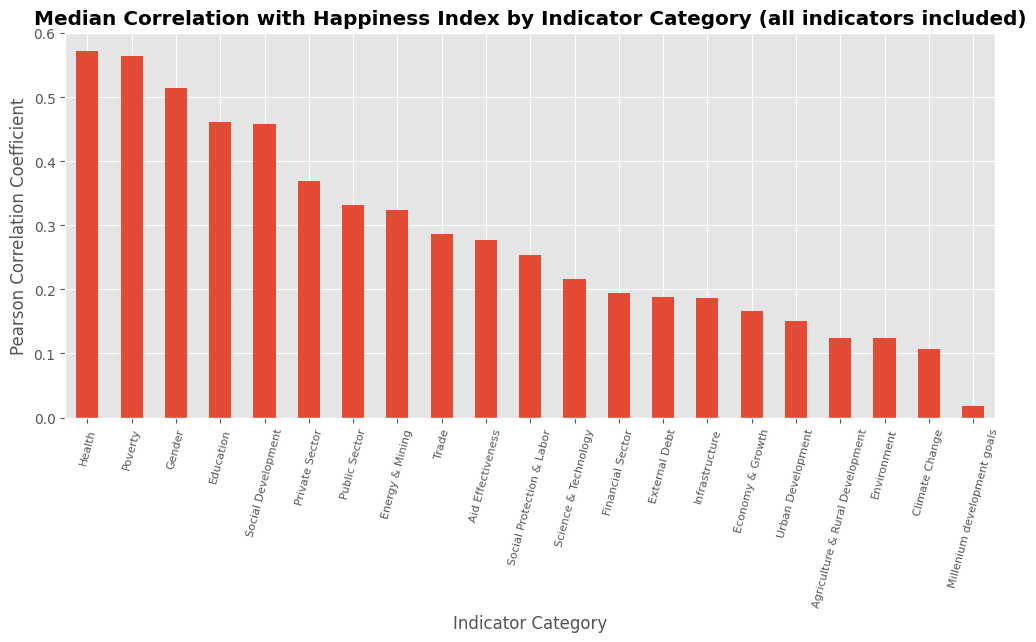

In [6]:
grouped=corr_df.groupby('category')['corr'].apply(lambda x:x.abs().median()).sort_values(ascending=False)

plt.figure(figsize=(12,5))
grouped.plot.bar()
plt.xticks(rotation=75, size=8)
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Indicator Category')
plt.title('Median Correlation with Happiness Index by Indicator Category (all indicators included)', fontweight='bold')
plt.show()

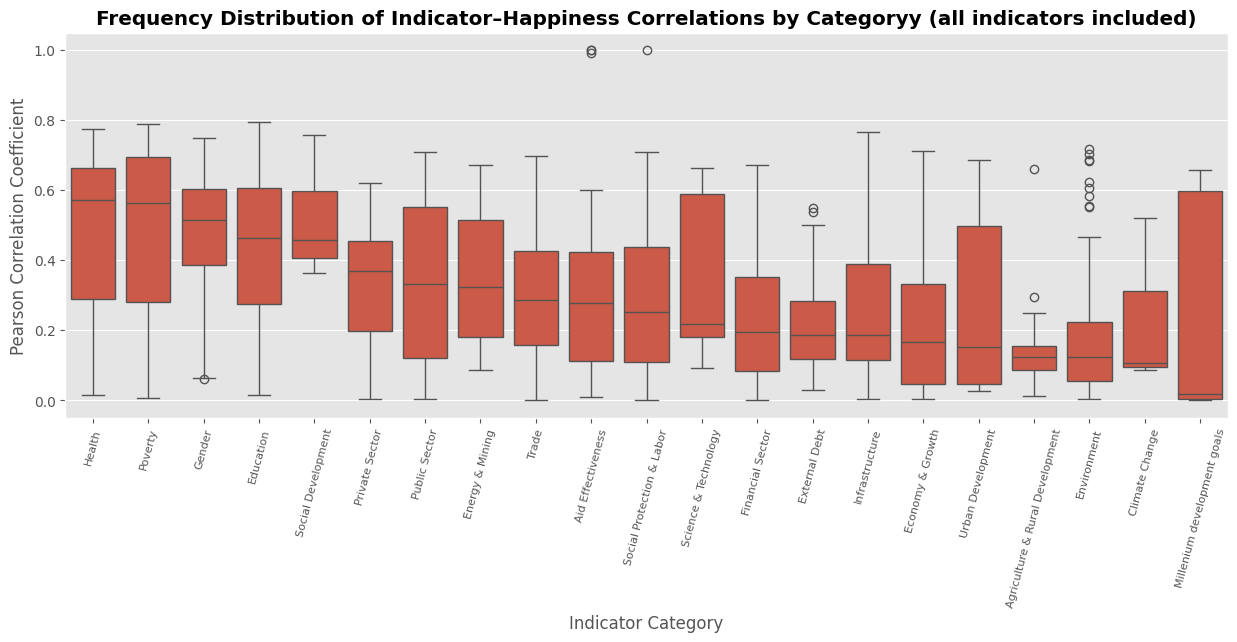

In [7]:
order =grouped.index

plt.figure(figsize=(15,5))
sns.boxplot(
    corr_df.assign(corr_abs=corr_df['corr'].abs()),
    x='category',
    y='corr_abs',
    order=order
)
plt.xticks(rotation=75, size=8)
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Indicator Category')
plt.title('Frequency Distribution of Indicator–Happiness Correlations by Categoryy (all indicators included)', fontweight='bold')
plt.show()

In [8]:
corr_df=corr_df[
    (corr_df['occurance'] >= 50) &
    (corr_df['corr'].abs() >= 0.7)
]


In [9]:
corr_df.groupby('category')['corr'].apply(lambda x:x.abs().median()).sort_values(ascending=False)

category
Education                    0.781909
Poverty                      0.756917
Social Development           0.752257
Gender                       0.731020
Infrastructure               0.723575
Health                       0.721346
Economy & Growth             0.711086
Environment                  0.710843
Public Sector                0.708124
Social Protection & Labor    0.707663
Name: corr, dtype: float64

In [10]:
df=df[df['indicator_name'].isin(corr_df['indicator'].unique().tolist())]
df['value']=df.filter(like='YR').mean(axis=1)
df=df[['country_code', 'indicator_name', 'value']]


In [11]:
merged=df.merge(happy_df, left_on='country_code', right_on='iso3')[['country_code', 'indicator_name', 'value','Happiness index, 2024']]

In [12]:
df_wide = merged.pivot(index=['country_code', 'Happiness index, 2024'], 
                   columns='indicator_name', 
                   values='value').reset_index()

                              OLS Regression Results                             
Dep. Variable:     Happiness index, 2024   R-squared:                       0.705
Model:                               OLS   Adj. R-squared:                  0.692
Method:                    Least Squares   F-statistic:                     55.94
Date:                   Fri, 26 Dec 2025   Prob (F-statistic):           1.98e-29
Time:                           23:01:06   Log-Likelihood:                -116.52
No. Observations:                    123   AIC:                             245.0
Df Residuals:                        117   BIC:                             261.9
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

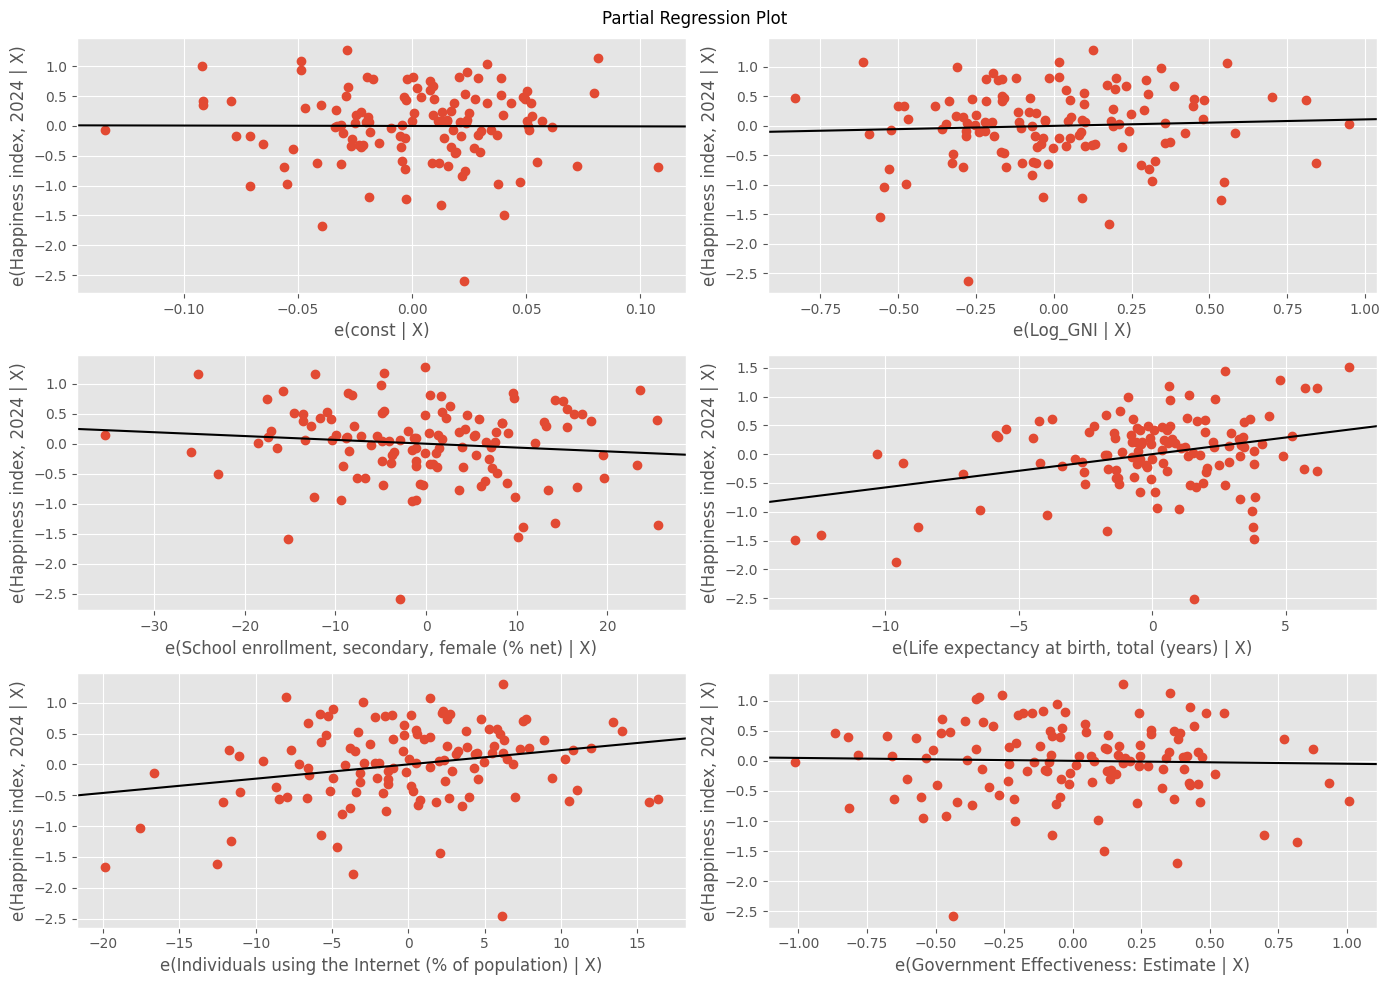

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load your dataset
df = pd.read_csv('df_wide.csv')

# 2. Define our Variables based on your columns
target = 'Happiness index, 2024'

# Control Variable (Wealth)
wealth_col = 'GNI per capita, PPP (constant 2021 international $)'

# Challenger Variables (Social, Health, and Digital)
edu_col = 'School enrollment, secondary, female (% net)'
health_col = 'Life expectancy at birth, total (years)'
infra_col = 'Individuals using the Internet (% of population)'
gov_col = 'Government Effectiveness: Estimate'

# 3. Data Cleaning
# Select variables and drop rows with missing values (123 countries remain)
cols_to_use = [target, wealth_col, edu_col, health_col, infra_col, gov_col]
data = df[cols_to_use].dropna()

# Apply log transformation to Wealth (Log-Linear Relationship)
data['Log_GNI'] = np.log(data[wealth_col])

# 4. Run Multivariate Regression
# We predict Happiness based on Wealth + Education + Health + Internet + Governance
X = data[['Log_GNI', edu_col, health_col, infra_col, gov_col]]
X = sm.add_constant(X) # Add intercept
y = data[target]

model = sm.OLS(y, X).fit()

# 5. Output the Results
print(model.summary())

# 6. Generate the Visual Proof (Partial Regression Plot)
# This shows the independent effect of each variable
fig = plt.figure(figsize=(14, 10))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.tight_layout()
plt.savefig('happiness_multivariate_proof.png')

print("\n--- STATISTICAL VERDICT ---")
for var in ['Life expectancy at birth, total (years)', 'Individuals using the Internet (% of population)']:
    p_val = model.pvalues[var]
    if p_val < 0.05:
        print(f"PROVEN: '{var}' has a significant effect (p={p_val:.4f}) independent of Wealth.")